# `aimmd.distributed.CommittorSimulation`
This notebook showcases how to steer a complete `CommittorSimulation` from python.

It assumes familiarity with the `GmxEngine`/`SlurmGmxEngine` and the `TrajectoryFunctionWrappers`, i.e. it is recommended to finish the notebooks `1_GmxEngine.ipynb` and `2_Conditional_trajectory_propagation_and_TrajectoryFunctionWrappers.ipynb`. As usual this notebook will only work if the gromacs executables are available.

### Imports and working directory

In [1]:
%%bash
# if using the module system to make gromacs and friends available:
# check that they are loaded!
#module list

In [2]:
%%bash
# unix only, check that gmx is available
which gmx

/usr/local/gromacs-2020.4/bin/gmx


In [3]:
%matplotlib inline

In [4]:
import os
import asyncio
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda

In [5]:
import aimmd
import aimmd.distributed as aimmdd

Tensorflow/Keras not available


In [6]:
# setup working directory

#scratch_dir = "."
#scratch_dir = "/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/"
scratch_dir = "/home/think/scratch/aimmd_distributed/"

workdir = os.path.join(scratch_dir, "Committors_test")

if not os.path.isdir(workdir):
    os.mkdir(workdir)

### Setup logging
Note that this is entirely optional, i.e. you can skip the next 3 cells if you like. However for now we want the loglevel to be 'INFO' to see everything/most of the stuff that is done (and possibly goes wrong).

In [7]:
# setup logging
# executing this file sets the variable LOGCONFIG, which is a dictionary of logging presets 
%run ../resources/logconf.py

In [8]:
# have a look at the default logging level (the level used for the logger without a name)
LOGCONFIG["loggers"][""]
# should be `INFO`

{'level': 'INFO', 'handlers': ['stdf', 'warnout']}

In [9]:
# you can either modify single values or use it as is to get the same setup as in the OPS default logging config file
# you could e.g. do LOGCONF['handlers']['stdf']['filename'] = new_name to change the filename of the log
# the default is to create 'simulation.log' and 'initialization.log' in the current working directory
import logging.config
LOGCONFIG["handlers"]["stdf"]["filename"] = os.path.join(workdir, "simulation_committors.log")
LOGCONFIG["handlers"]["initf"]["filename"] = os.path.join(workdir, "initlog_committors.log")
logging.config.dictConfig(LOGCONFIG)

# `aimmd.distributed.CommittorSimulation` setup
The `CommittorSimulation` is a python class to steer/control multiple molecular simulations at the same time. It takes a list of starting configurations and the states to then propagate the trajectories (usually in chunks of walltime) until any of the states is reached. It supports oneway and twoway shooting (the later not beeing a true committor simulation because forward and backwards trajectories are correlated) and is the highlevel user-facing object to perform committor simulations.

To initialize and run a `CommittorSimulation` you need:
- `workdir`: The toplevel directory the simulation will run in
- `starting_configurations`: A list, every entry in the list corresponds to one configuration and must be an iterable itself, the single list entry structure is: `aimmd.distributed.Trajectory`, `index_of_conf_in_traj`, `name_for_configuration`; Note that the `name_for_configuration` is optional and will be used only as the name of the (sub)folder in which the trials for that configuration will be performed, if no name is supplied the folder will simply be named `configuration_$CONFNUM`
- `states`: A list of state functions, preferably wrapped using a `aimmd.distributed.TrajectoryFunctionWrapper`
- `engine_cls`: The class of the molecular dynamics engine to use, should be a sublcass of `aimmd.distributed.MDEngine`
- `engine_kwargs`: A dictionary with keyword arguments that can/will be used to instatiate the molecular dynamics engine
- `engine_run_config`: The molecular dynamics parameters, should be a subclass of `aimmd.distributed.MDConfig`
- `T`: float, the temperature to use when generating random Maxwell-Boltzmann velocities
- `walltime_per_part`: float, (maximum) walltime per trajectory segment in hours; Note that this does not determine the total length of the trajectories but only the size of the single trajectory segments
- `n_max_concurrent`: int, the maximum number of trials to propagate concurrently; Note for two way simulations you will run 2*`n_max_concurrent` molecular dynamic simulations in parallel
- `max_steps`: int or None, the maximum number of integration steps to perform in total per trajectory, i.e. for two way simulations the combined maximum length of the resulting trajectory will be 2*`max_steps`

Note that you can set all attributes of the `CommittorSimulation` (`fname_traj_to_state`, `fname_transition_traj`, `deffnm_engine_out`, etc.) at initialization time by passing them as keyword arguments with the respective values you want to use.


Also Note, that the `CommittorSimulation` is quite flexible and allows the simulation of different physical ensembles for every starting configuration. This is achieved by allowing the parameters `engine_cls`, `engine_kwargs`, `engine_run_config`, `T` and `twoway` to be either singletons (i.e. the same for the whole committor simulation) or a list with the same length as `starting_configurations` (i.e. one value per starting configuration). This means you can simulate systems differing in the number of molecules (by changing the topology used in the engine), at different pressures (by changing the molecular dynamics parameters passed with `engine_run_config`), at different temperatures (by changing `T` and the parameters in the `engine_run_config`) and even perform two way shots only for a selected subset of starting configurations (e.g. the ones you expect to be a transition state).

If the `CommittorSimulation` options still are not flexible enough for your needs you can always use the `TrajectoryPorpagatorUntilAnyState` (which is used under the hood anyway) to implement your own committor simulation from scratch.

In [10]:
# import state functions
from state_funcs_mda import alpha_R, C7_eq

# and wrapp them
wrapped_alphaR = aimmdd.PyTrajectoryFunctionWrapper(alpha_R)
wrapped_C7_eq = aimmdd.PyTrajectoryFunctionWrapper(C7_eq)

In [11]:
# Load the transition to take initial configurations from 
tp_traj = aimmdd.Trajectory(trajectory_file="gmx_infiles/ala_400K_TP_low_barrier.trr",
                            structure_file="gmx_infiles/conf.gro")
print(f"The transition has a length of {len(tp_traj)} frames.")

The transition has a length of 26 frames.


In [12]:
# prepare a list of starting configurations
# we will take each frame of the transition once except the first and last frame (these are already inside the states)
# OPTIONAL: we will name each configuration 'frame$FRAMENUM_from_low_barrier_transition',
#           we could also just have used tuples of length 2: (traj, idx) and then every configuration would just get an index
starting_confs = [(tp_traj, i, f"frame{i}_from_low_barrier_transition") for i in range(1, len(tp_traj) - 1)]

In [13]:
# engine_kwargs
gro = "gmx_infiles/conf.gro"
top = "gmx_infiles/topol.top"
ndx = "gmx_infiles/index.ndx"
mdp = aimmdd.MDP("gmx_infiles/md.mdp")

print(f"The reference temperature ('ref-t') in the mdp file is: {mdp['ref-t']}.")

engine_kwargs = {"gro_file":gro, "top_file":top, "ndx_file":ndx,
                 "mdrun_extra_args":"-nt 1",  # use this for GMX with (thread) MPI support
                 #"mdrun_extra_args": "-ntomp 1",  # and this for GMX sans (thread) MPI support
                 }

# here we simply use the `singleton` options for all configurations,
# i.e. all molecular dynamics simulations of this committor simulation sample the same ensemble
simulation = aimmdd.CommittorSimulation(workdir=workdir,
                                        starting_configurations=starting_confs,
                                        states=[wrapped_alphaR, wrapped_C7_eq],
                                        engine_cls=aimmdd.GmxEngine,
                                        engine_kwargs=engine_kwargs,
                                        engine_run_config=mdp,
                                        T=mdp["ref-t"][0],
                                        walltime_per_part=0.01,  # run in simulation parts of 36 seconds 
                                        n_max_concurrent=10,  # start a maximum of 8 md engines engines (*2 if twoway)
                                        two_way=False,
                                        wait_time_on_crash=30,  # time to wait on engine crash until retrying (in seconds)
                                        max_retries_on_crash=5,  # maximum number of retries on crash, e.g. 5 means try at most 6 times
                                        )

The reference temperature ('ref-t') in the mdp file is: [300.0, 300.0].


In [14]:
# now run the simulation for 10 shots per configuration
ret = await simulation.run(10)

/home/think/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/MDAnalysis/topology/tpr/utils.py:389: DeprecationWarning: TPR files index residues from 0. From MDAnalysis version 2.0, resids will start at 1 instead. If you wish to keep indexing resids from 0, please set `tpr_resid_from_one=False` as a keyword argument when you create a new Topology or Universe.
  warnings.warn("TPR files index residues from 0. "
/home/think/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/MDAnalysis/topology/tpr/utils.py:389: DeprecationWarning: TPR files index residues from 0. From MDAnalysis version 2.0, resids will start at 1 instead. If you wish to keep indexing resids from 0, please set `tpr_resid_from_one=False` as a keyword argument when you create a new Topology or Universe.
  warnings.warn("TPR files index residues from 0. "
/home/think/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/MDAnalysis/topology/tpr/utils.py:389: DeprecationWarning: TPR files index res

EngineCrashedError: Non-zero exit code from mdrun. Exit code was: -11.

In [15]:
print(simulation.max_retries_on_crash)
print(simulation.wait_time_on_crash)

5
30


# Have a look at and plot the results

In [16]:
import matplotlib

### Plot results for every starting configuration and shot seperately

NameError: name 'ret' is not defined

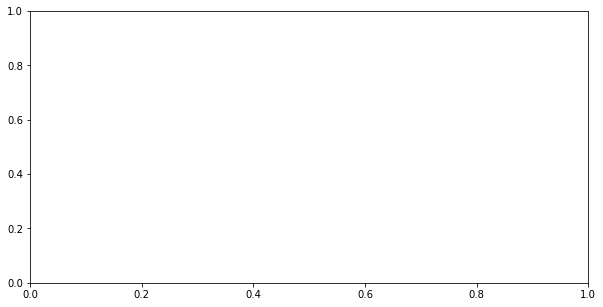

In [17]:
fig, axs = plt.subplots(figsize=(10, 5))

# ret are the shooting results per stucture and shot, i.e. it has shape = (n_conf, n_shot, n_states)
# it is the same as `CommittorSimulation.states_reached_per_shot`
n_conf, n_shot, n_states = ret.shape
xses_per_conf = np.arange(0, 10)
# get a colorbar and a normalize instance to have different colors for starting structure
cmap = matplotlib.cm.get_cmap("viridis")
norm = matplotlib.colors.Normalize(vmin=0, vmax=n_conf-1)

for cnum, conf in enumerate(ret):
    # NOTE: this only works if ret is per configuration and per shot, i.e. if it can only have one True value (one 1) per array in the last axis
    plot_vals = np.zeros((n_shot,))  # fill with the plot values
    idxs, state = np.where(conf)  # will return the idxs of the shot and idx of the state each shot reached
    plot_vals[idxs] = state
    axs.scatter(x=xses_per_conf + (n_shot * cnum),
                y=plot_vals,
                color=cmap(norm(cnum)),
                )

axs.set_yticks([i for i in range(n_states)])
axs.set_yticklabels(["alpha_R", "C7_eq"], size=14)
axs.set_xlabel("Configuration/shot index", size=14)
axs.set_ylabel("State reached", size=14)

### Plot committor estimates for every starting configuration, i.e. aggregated for every starting structure

In [ ]:
fig, axs = plt.subplots(figsize=(10,6), nrows=n_states, sharex=True)
# states_reached already aggregates the reulst for the same starting configuration
# it therefore has shape = (n_conf, n_states)
n_conf, n_states = simulation.states_reached.shape
for snum, ax in enumerate(axs):
    ax.set_title(f"Committor towards state {snum}")
    ax.scatter(x=np.arange(n_conf),
               y=simulation.states_reached[:, snum] / np.sum(simulation.states_reached, axis=1),
               c=cmap(norm(np.arange(n_conf))),
               )
    ax.set_ylim(-0.1, 1.1)

# "Continuation" of the trials that reached only one state
This is a bit stupid, but just to showcase the possiblity to rerun a `CommittorSimulation` on an existing directory/run with possibly changed states. To this end, we will simply run the `CommittorSimulation` with only one state (the one we did not reach on the trials we rerun on). We will take the first few trials (started from configurations on the transition that are close(r) to C7_eq) as they should all/mostly have reached the C7_eq state and run a committor continuation with alpha_R as the only target state. This will result in continuing all choosen trial until they reach alpha_R (ignoring that they first reached C7_eq because the new `CommittorSimulation` does not know about C7_eq anymore).

Additionally we will set `twoway=True` to also add the backwards shots for all of the configurations we now look at again. The twoway shooting can be used to generate initial transitions for a subsequent transition path sampling simulation. Note however that this is usually only smart for configurations that have an roughly equal probability to reach both/multiple states, i.e. for potential transition states.

In [ ]:
# take the first 10 starting configurations for continuation, they will mostly have ended up in C7_eq
first_n_starting_configurations_to_take = 10

In [ ]:
new_simulation = aimmdd.CommittorSimulation(workdir=workdir,
                                            # take only a subset of the original starting configurations
                                            starting_configurations=starting_confs[:first_n_starting_configurations_to_take],
                                            states=[wrapped_alphaR], # only alpha_R as target state
                                            engine_cls=aimmdd.GmxEngine,
                                            engine_kwargs=engine_kwargs,
                                            engine_run_config=mdp,
                                            T=mdp["ref-t"][0],
                                            walltime_per_part=0.01,  # run in simulation parts of 36 seconds 
                                            n_max_concurrent=8,  # start a maximum of 8 md engines engines (*2 if twoway)
                                            # NOTE: we changed twoway=True
                                            two_way=True,
                                            wait_time_on_crash=30,  # time to wait on engine crash until retrying (in seconds)
                                            max_retries_on_crash=5,  # maximum number of retries on crash, e.g. 5 means try at most 6 times
                                            # make sure we name the concatenated output trajs differently this time
                                            fname_traj_to_state="continuation_traj_to_state.trr",
                                            fname_traj_to_state_bw="continuation_traj_to_state_bw.trr",
                                            # not really needed, there can be no transitions with only one state anyway
                                            fname_transition_traj="transition_traj.trr",
                                           )

In [ ]:
new_ret = await new_simulation.reinitialize_from_workdir()

In [ ]:
# some more shots in the old simulation which knows abouts both states
new_shots = await simulation.run(20)

In [ ]:
await wrapped_alphaR(tp_traj)

In [ ]:
await wrapped_C7_eq(tp_traj)

/home/think/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/MDAnalysis/topology/tpr/utils.py:389: DeprecationWarning: TPR files index residues from 0. From MDAnalysis version 2.0, resids will start at 1 instead. If you wish to keep indexing resids from 0, please set `tpr_resid_from_one=False` as a keyword argument when you create a new Topology or Universe.
  warnings.warn("TPR files index residues from 0. "
/home/think/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/MDAnalysis/topology/tpr/utils.py:389: DeprecationWarning: TPR files index residues from 0. From MDAnalysis version 2.0, resids will start at 1 instead. If you wish to keep indexing resids from 0, please set `tpr_resid_from_one=False` as a keyword argument when you create a new Topology or Universe.
  warnings.warn("TPR files index residues from 0. "
/home/think/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/MDAnalysis/topology/tpr/utils.py:389: DeprecationWarning: TPR files index res